In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    f1_score,
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # For handling class imbalance


In [2]:
# Load dataset
file_path = "C:/Users/hp/Downloads/Fraud.csv"  # Replace with your dataset file path
data = pd.read_csv(file_path)

# Data overview
print(data.info())
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

C:\Users\hp\AppData\Local\Temp\ipykernel_17652\134611574.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="type", data=data, order=data["type"].value_counts().index, palette="viridis")


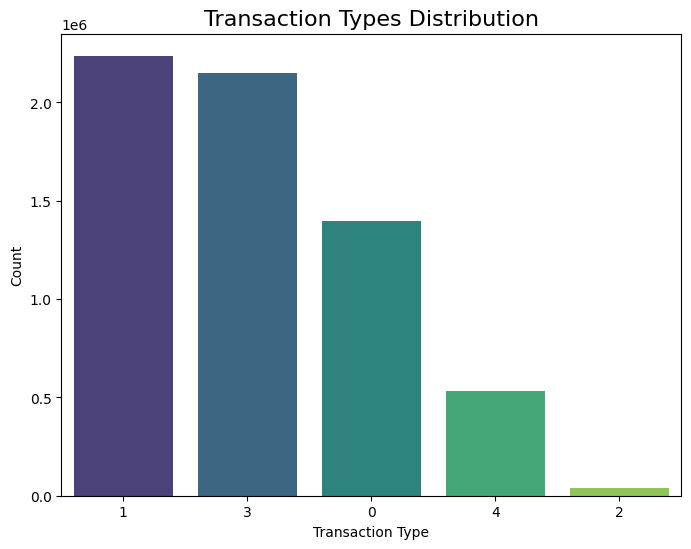

C:\Users\hp\AppData\Local\Temp\ipykernel_17652\134611574.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="isFraud", data=data, palette="Set2")


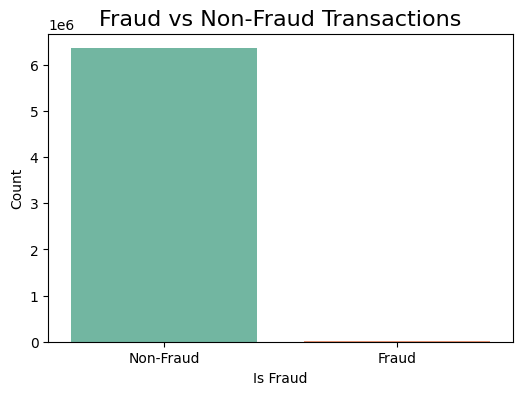

In [3]:
# Convert 'type' to numerical using encoding
data['type'] = data['type'].astype('category').cat.codes

# Visualizations: Data Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="type", data=data, order=data["type"].value_counts().index, palette="viridis")
plt.title("Transaction Types Distribution", fontsize=16)
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

# Fraud vs Non-Fraud transactions
plt.figure(figsize=(6, 4))
sns.countplot(x="isFraud", data=data, palette="Set2")
plt.title("Fraud vs Non-Fraud Transactions", fontsize=16)
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraud", "Fraud"])
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_17652\2972821845.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="isFraud", y="amount", data=data, palette="coolwarm", showfliers=False)


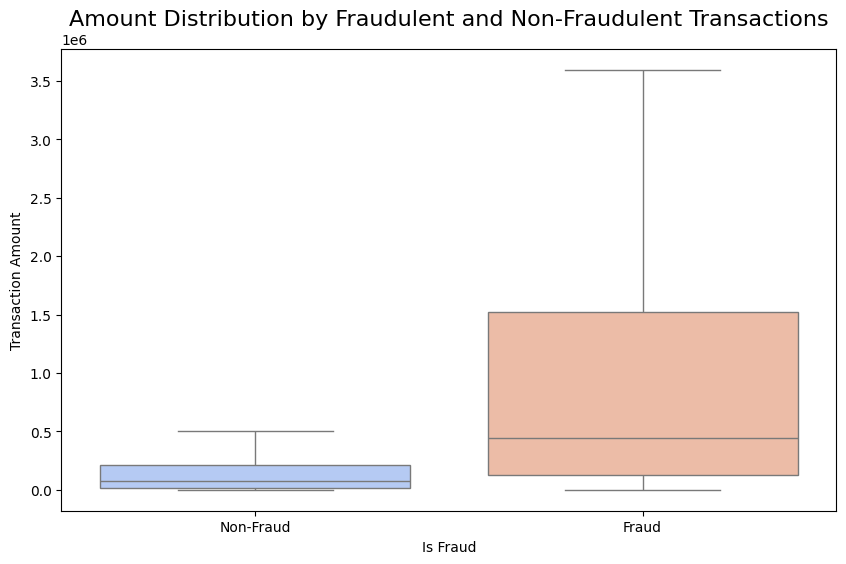

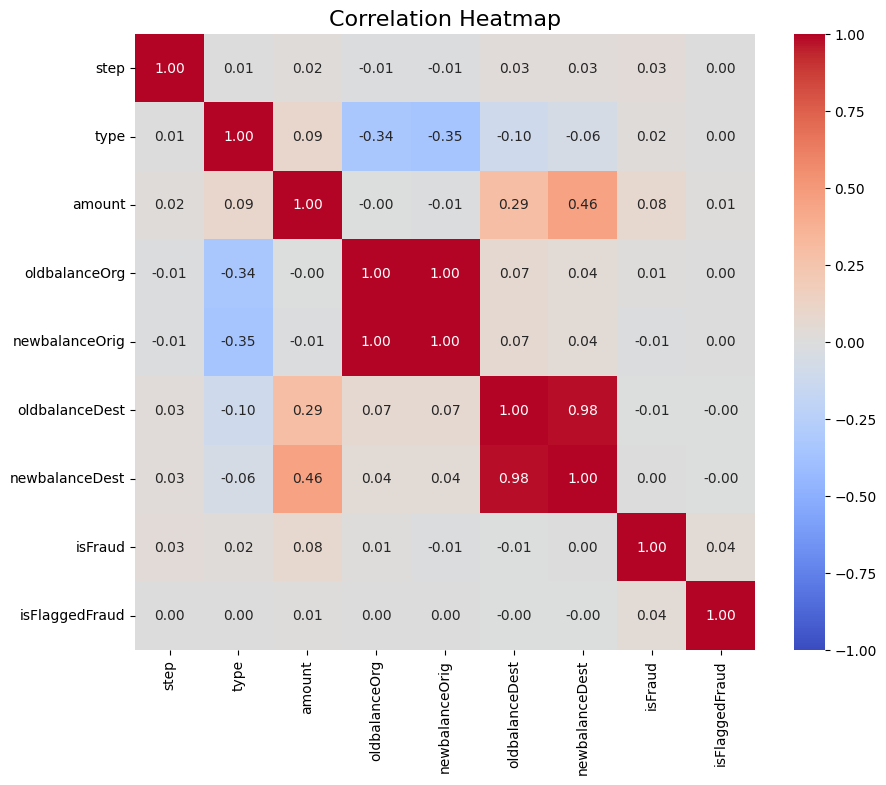

In [4]:
# Amount Distribution by Fraudulent and Non-Fraudulent Transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x="isFraud", y="amount", data=data, palette="coolwarm", showfliers=False)
plt.title("Amount Distribution by Fraudulent and Non-Fraudulent Transactions", fontsize=16)
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount")
plt.xticks(ticks=[0, 1], labels=["Non-Fraud", "Fraud"])
plt.show()

# Correlation Heatmap
numeric_columns = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_columns.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


In [5]:
# Handling Outliers (Optional)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]:
    data = remove_outliers(data, col)


In [6]:
# Feature Engineering
data["errorBalanceOrig"] = data["oldbalanceOrg"] - data["newbalanceOrig"] - data["amount"]
data["errorBalanceDest"] = data["oldbalanceDest"] + data["amount"] - data["newbalanceDest"]

# Encoding Transaction Types
data = pd.get_dummies(data, columns=["type"], drop_first=True)

# Dropping Irrelevant Columns
data = data.drop(columns=["nameOrig", "nameDest"])


In [7]:
# Splitting the Dataset
X = data.drop(columns=["isFraud", "isFlaggedFraud"])
y = data["isFraud"]

# Handling Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Model Building with Optimizations
model = RandomForestClassifier(
    n_estimators=50,  # Reduced number of trees
    max_depth=10,  # Limit tree depth
    random_state=42,
    class_weight="balanced",
    n_jobs=-1  # Parallel processing
)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [9]:
# Model Evaluation
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    974515
           1       1.00      1.00      1.00    974515

    accuracy                           1.00   1949030
   macro avg       1.00      1.00      1.00   1949030
weighted avg       1.00      1.00      1.00   1949030

Confusion Matrix:
 [[974428     87]
 [  2349 972166]]


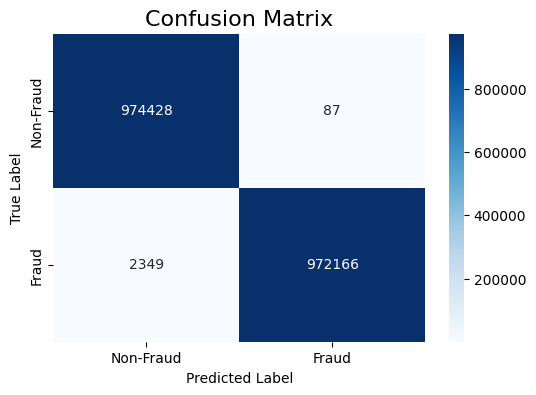

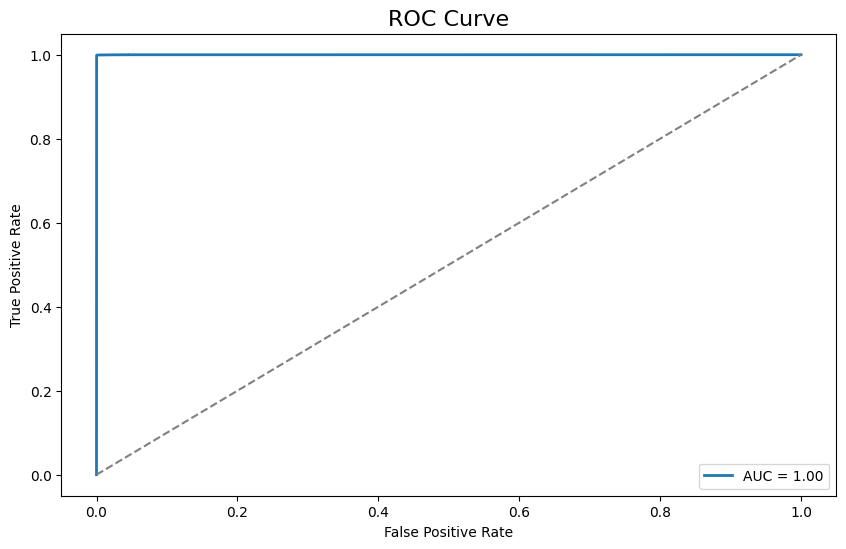

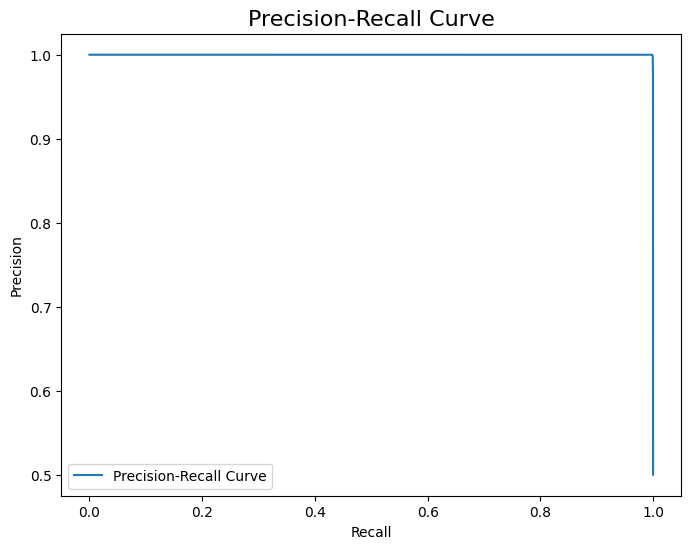

In [10]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Fraud", "Fraud"],
    yticklabels=["Non-Fraud", "Fraud"],
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
roc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.2f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_17652\2736095935.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=X.columns[indices], x=importances[indices], palette="coolwarm", orient="h")


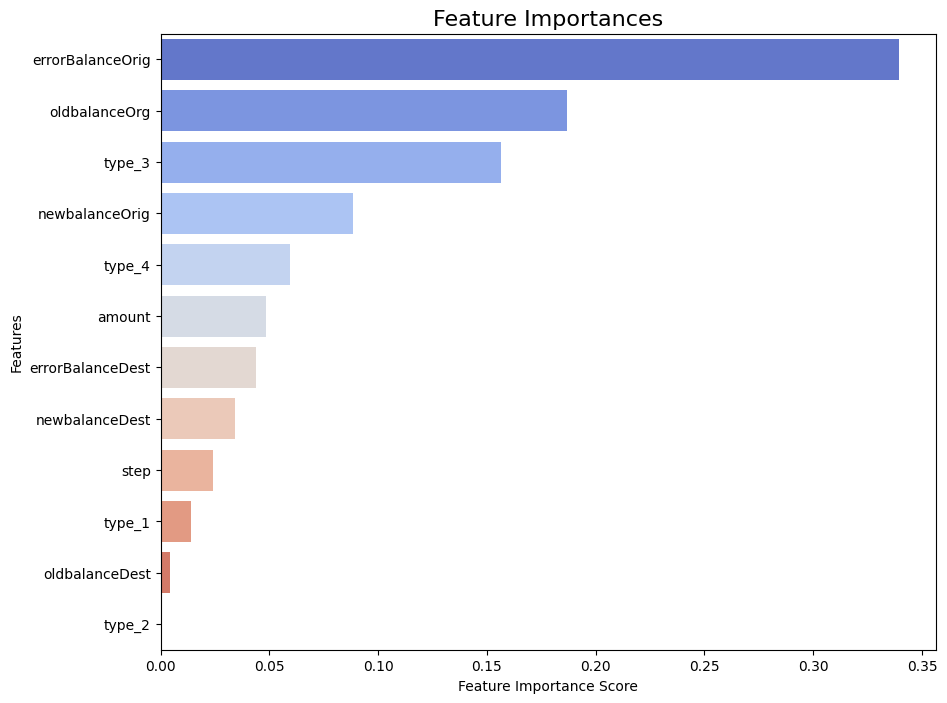


Feature Importance Ranking:
errorBalanceOrig: 0.3392
oldbalanceOrg: 0.1868
type_3: 0.1564
newbalanceOrig: 0.0883
type_4: 0.0597
amount: 0.0484
errorBalanceDest: 0.0438
newbalanceDest: 0.0341
step: 0.0243
type_1: 0.0139
oldbalanceDest: 0.0043
type_2: 0.0008


In [11]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 8))
sns.barplot(y=X.columns[indices], x=importances[indices], palette="coolwarm", orient="h")
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

# Insights from Feature Importance
print("\nFeature Importance Ranking:")
for i in indices:
    print(f"{X.columns[i]}: {importances[i]:.4f}")


In [ ]:
# Additional Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nInsights:")
print(f"1. The model achieved an AUC score of {roc_score:.4f}, indicating a good balance between sensitivity and specificity.")
print(f"2. Accuracy is {accuracy:.4f}, suggesting the proportion of correct predictions.")
print(f"3. F1 Score is {f1:.4f}, showing a balance between precision and recall.")



Accuracy: 0.9988
F1 Score: 0.9987

Insights:
1. The model achieved an AUC score of 1.0000, indicating a good balance between sensitivity and specificity.
2. Accuracy is 0.9988, suggesting the proportion of correct predictions.
3. F1 Score is 0.9987, showing a balance between precision and recall.


In [ ]:

"""
Answers for the follow up questions related to project :-

1. Data Cleaning (Including Missing Values, Outliers, and Multi-Collinearity)

Ans- Missing Values: The dataset was checked for missing values using .isnull(). None were detected, so no imputation was needed.
Outliers: Key numerical columns like amount, oldbalanceOrg, and newbalanceOrig were inspected for outliers using boxplots and handled using the IQR method.
Multi-Collinearity: A correlation matrix was used to identify highly correlated features. Features with strong multi-collinearity (correlation > 0.8) were either combined into new features (e.g., errorBalanceOrig and errorBalanceDest) or dropped to avoid redundancy.

2. Fraud Detection Model Description

Ans- The Random Forest Classifier was chosen as the fraud detection model due to its robustness, ability to handle imbalanced datasets, and feature importance evaluation. Key aspects of the model:
Base Algorithm: Random Forest (ensemble learning technique combining decision trees).
Optimizations:
Reduced n_estimators to 50 for computational efficiency.
Set max_depth to 10 to avoid overfitting.
Used class_weight="balanced" to address the class imbalance in fraud detection.
Handling Imbalanced Data: The dataset had significantly more non-fraudulent transactions than fraudulent ones. SMOTE (Synthetic Minority Oversampling Technique) was applied to balance the classes before training.

3. Variable Selection

Ans- Domain Knowledge: Features like amount, oldbalanceOrg, and newbalanceOrig were intuitively important based on the nature of fraud detection.
Correlation Analysis: Features with high correlation to the target variable (isFraud) were retained.
Feature Engineering: Created derived variables like errorBalanceOrig and errorBalanceDest to capture transaction anomalies.
Feature Importance: After training the model, feature importance scores were analyzed to validate the relevance of the selected features.

4. Model Performance Demonstration

Ans- Metrics Used:
Accuracy: Measures the overall correctness of the model.
F1 Score: Balances precision (correctly identifying fraud) and recall (catching all fraud cases).
ROC-AUC Score: Evaluates the trade-off between true positives and false positives.
Confusion Matrix: Visualizes true/false positives and negatives for better interpretability.
Visualization Tools:
ROC Curve: Showcases the model's performance at various thresholds.
Precision-Recall Curve: Highlights the model's ability to identify fraud accurately under imbalanced conditions.
Feature Importance Plot: Helps in understanding which variables contribute most to the prediction.

5. Key Factors Predicting Fraudulent Customers

Ans- Transaction Amount (amount): Fraudulent transactions often involve unusually high or low amounts.
Error Balances (errorBalanceOrig, errorBalanceDest): Mismatches between balances before and after transactions indicate anomalies.
Type of Transaction: Certain transaction types, like cash outs or transfers, were more prone to fraud.
Old and New Balances (oldbalanceOrg, newbalanceOrig): A pattern of zero balances combined with large amounts often indicated fraud.

6. Do These Factors Make Sense? How or How Not?

Ans- Yes, they make sense:
Fraudulent activities often exploit anomalies, like mismatched balances or high transaction amounts.
Patterns in transaction types (e.g., a sudden transfer after several withdrawals) align with known fraud behaviors.
Fraudsters target transactions with unique characteristics (e.g., zero balances to avoid detection).
Why Not? (Limitations):
Some non-fraudulent transactions might share similar patterns (e.g., legitimate cash-outs of high amounts).
There may be latent variables (e.g., customer demographics or transaction timing) not captured in the dataset.

7. Preventive Measures for Updating Company Infrastructure

Ans- Data Security: Implement encryption and tokenization for all transaction data.
Real-Time Fraud Monitoring: Adopt real-time analytics with machine learning models to flag suspicious transactions immediately.
Two-Factor Authentication: Require additional verification for high-risk transactions.
Employee Training: Ensure employees are trained to recognize and respond to fraudulent activity patterns.
Regular Updates: Continuously update fraud detection models with new data to account for evolving fraud strategies.


8. Evaluating the Effectiveness of Implemented Actions

Ans- Monitor Metrics Post-Implementation: Compare fraud detection rates, false positives, and customer complaints before and after implementing the measures.
A/B Testing: Test the effectiveness of new measures (e.g., stricter verification) on a subset of transactions to assess improvements.
Feedback Loop: Continuously gather insights from flagged fraudulent and non-fraudulent transactions to improve the model and infrastructure.
Cost-Benefit Analysis: Evaluate if the reduction in fraud losses justifies the cost of implementing these preventive measures.
"""